In [1]:
!nvidia-smi

Thu Jan 14 13:59:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.48                 Driver Version: 410.48                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-SXM2...  Off  | 00000000:05:00.0 Off |                    0 |
| N/A   30C    P0    40W / 300W |  11108MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-SXM2...  Off  | 00000000:06:00.0 Off |                    0 |
| N/A   29C    P0    41W / 300W |   5985MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="3"

# test.py

In [3]:
import argparse
import logging
import os
import sys
from tqdm import tqdm
import yaml
import time

import numpy as np
import torch
from torch import optim
from torch.utils.data import DataLoader, random_split
# from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.nn.functional as F

from model.model import LogoDetection
from utils.dataset_loader import BasicDataset
from eval import eval_net


# todo: when we add more models, we should move these variables to another location
ALL_MODEL_NAMES = ["LogoDetection"]
ALL_DATASET_NAMES = ["FlickrLogos-32", "TopLogos-10"]

# Print full np array 
# import sys
# import numpy
# numpy.set_printoptions(threshold=sys.maxsize)

with open(os.path.abspath("./config/config.yaml")) as config:
    config_list = yaml.load(config, Loader=yaml.FullLoader)

# def pred(model,
#          sample,
#          device,
#          threshold=0.5):
#     if(model.eval==False):
#         model.eval()

#     queries, targets = torch.from_numpy(BasicDataset.preprocess(index=index, file:files_path))
#     queries = queries.unsqueeze(0)
#     queries = queries.to(device=device, dtype=torch.float32)
#     targets = targets.unsqueeze(0)
#     targets = targets.to(device=device, dtype=torch.float32)


def test(model,
         device,
         loader,
         batch_size,
        #   save_path,
         verbose: bool,
         threshold=0.5):
    
    model.eval()

    # #TODO dataset preprocessing
    # with torch.no_grad():
    #     output = model(queries, targets)

    #     probs = output.squeeze(0)
    
    logging.info("\nPredicting image{} ... ")
    print(f"loader: {len(loader)}")
    
    val_scores = []

#     with tqdm(total=len(loader), desc=f'Testing dataset', unit='test-img', disable=not verbose) as bar:
#             bar.set_description(f'model testing')

#             for batch in loader:
#                 queries = batch['query']  # Correct dimensions?
#                 targets = batch['target']
#                 bboxes = batch['mask']

#                 queries = queries.to(device=device, dtype=torch.float32)
#                 targets = targets.to(device=device, dtype=torch.float32)
#                 bboxes = bboxes.to(device=device, dtype=torch.float32)

#                 with torch.no_grad():
#                     pred_masks = model(queries, targets)
#                     # print(pred_masks.shape)

#                     global_step += 1
    val_score = eval_net(model=model, loader=loader, device=device, bbox=False, verbose=True)
#    val_scores.append(val_score)
#             bar.update(queries.shape[0])
                # writer.add_scalar('learning_rate', optimizer.param_groups[0]['lr'], global_step)

#                 writer.add_images('query_images', queries, global_step)
#                 writer.add_images('target_images', targets, global_step)
#                 # writer.add_images('bboxes/true', bboxes, global_step)
#                 writer.add_images('masks/pred', pred_masks, global_step)
#                 writer.close()
    return val_score


# def get_args():
#     parser = argparse.ArgumentParser()
#     parser.add_argument('--dataset',
#                         choices=ALL_DATASET_NAMES,
#                         help="Dataset in {}".format(ALL_DATASET_NAMES),
#                         required=True
#                         )

#     parser.add_argument('--model',
#                         choices=ALL_MODEL_NAMES,
#                         help="Model in {}".format(ALL_MODEL_NAMES)
#                         )

#     parser.add_argument('--batch_size',
#                         default=32,
#                         type=int,
#                         help="Number of samples in each mini-batch in SGD and Adam optimization"
#                         )

#     parser.add_argument('--verbose',
#                         default=True,
#                         type=bool,
#                         help="Verbose"
#                         )

#     parser.add_argument('--load',
#                         type=str,
#                         required=True,
#                         help="Path to the model to load"
#                         )

#     return parser.parse_args()


# if __name__ == '__main__':
def test_main(load: str = "",
    dataset_name: str = "FlickrLogos-32",
    model: str = "LogoDetection",
    batch_size: int = 32,
    verbose: bool = True,
    batch_norm: bool = True,
    vgg_cfg: str = 'B',
    skip_bbox_lines: int = 1
    ):
    # Logging
    logging.basicConfig(level=logging.INFO, format="%(asctime)s | %(levelname)s: %(message)s", filename='oneshot_test.log', filemode='w')
#     args = get_args()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    logging.info(f'Using device {device}')

    # Modularized paths with respect to the current Dataset
    imgs_dir = config_list['datasets'][dataset_name]['paths']['images']
    masks_dir = config_list['datasets'][dataset_name]['paths']['masks']
    # TODO: Controlla che ste due liste hanno le stesse sottocartelle, ma c'è la "no-logo" e non credo sia la migliore delle idee
    imgs_classes = [f.name for f in os.scandir(imgs_dir) if f.is_dir()]
    mask_classes = [f.name for f in os.scandir(masks_dir) if f.is_dir()]
    checkpoint_dir = config_list['models'][model]['paths']['train_cp']

    model_path = config_list['models'][model]['paths']['model']+ os.path.sep + "_".join([model, dataset_name]) + ".pt"

    # print("Loading %s dataset..." % args.dataset)
    # dataset = BasicDataset(imgs_dir=imgs_dir, masks_dir=masks_dir)

    # Change here to adapt your data
    print("Initializing model...")
    model = LogoDetection(batch_norm=batch_norm, vgg_cfg=vgg_cfg)

    if load:
        if os.path.isfile(load):
            print("Daje")
            load_path = load
        else:
            print("Nope")
    else:
#         if os.path.isfile(model_path):
#             load_path = model_path
#         else:
            if os.path.isdir(checkpoint_dir):
                onlyfiles = [f for f in os.listdir(checkpoint_dir) if os.path.isfile(os.path.join(checkpoint_dir, f)) and '.pt' in f]
                load_path = f'{checkpoint_dir}{os.path.sep}{onlyfiles[0]}'
    print(f"load_path: {load_path}")
    model.load_state_dict(
        torch.load(load_path, map_location=device),
        strict=False
    )
    logging.info(f'Model loaded: {load_path}')
    model.to(device=device)

    # Neo, enter in Metrics
    metrics = []
    
    print(f"imgs_classes: {imgs_classes}")
    logging.info(f"imgs_classes: {imgs_classes}")

    for img_class_idx, img_class_path in enumerate(imgs_classes):
        print(f"img_class_path: {img_class_path}")
        logging.info(f"img_class_path: {img_class_path}")
        dataset = BasicDataset(imgs_dir=f"{imgs_dir}{os.path.sep}{img_class_path}", masks_dir=f"{masks_dir}{os.path.sep}{img_class_path}", dataset_name=dataset_name, skip_bbox_lines=skip_bbox_lines)
#         dataset = BasicDataset(imgs_dir=f"{imgs_dir}", masks_dir=f"{masks_dir}", dataset_name=dataset_name, skip_bbox_lines=skip_bbox_lines)
#         test_loader = random_split(dataset, [len(dataset)])
        test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

#         if "adidas" in img_class_path:
        try:
            metrics.append(float(test(model=model,
                                device=device,
                                loader=test_loader,
                                batch_size=batch_size,
                                verbose=verbose
                                )))
            print(f"metrics: {metrics}")
            logging.info(f"metrics: {metrics}")
        except KeyboardInterrupt:
            # torch.save(model.state_dict(), 'INTERRUPTED.ph')w
            # logging.info('Interrupt saved')
            logging.info("Test interrupted")
            try:
                sys.exit(0)
            except SystemExit:
                os._exit(0)
    logging.info(f"Mean Average Precision: {sum(metrics)/len(imgs_classes)}")


/home/nvidia/anaconda3/envs/py37/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


Initializing model...
Daje
load_path: data/stored_models/checkpoints/CP_epoch45.pt


Validation round:   0%|          | 0/5 [00:00<?, ?samples/s]

imgs_classes: ['gucci', 'lacoste', 'nike', 'puma', 'adidas0', 'hh', 'supreme', 'prada', 'chanel', 'mk']
img_class_path: gucci
You have 70 triplets
loader: 5
truth_bboxes:  [(77, 142, 120, 69)]
truth_bboxes:  [(13, 73, 227, 90)]
truth_bboxes:  [(156, 148, 37, 13)]
truth_bboxes:  [(10, 8, 90, 25)]
truth_bboxes:  [(46, 118, 71, 27), (82, 23, 76, 29)]
truth_bboxes:  [(148, 131, 60, 34)]
truth_bboxes:  [(74, 28, 40, 38)]
truth_bboxes:  [(84, 33, 92, 31)]
truth_bboxes:  [(89, 35, 95, 40)]
truth_bboxes:  [(167, 117, 48, 21)]
truth_bboxes:  [(55, 105, 36, 13), (155, 119, 20, 8)]
truth_bboxes:  [(156, 128, 46, 21)]
truth_bboxes:  [(93, 154, 68, 35), (177, 190, 13, 35)]
truth_bboxes:  [(162, 120, 39, 21)]
truth_bboxes:  [(88, 12, 72, 10)]


Validation round: 16samples [00:09,  1.77samples/s]         

truth_bboxes:  [(72, 15, 137, 23)]
truth_bboxes:  [(115, 115, 124, 21)]
truth_bboxes:  [(151, 100, 31, 8)]
truth_bboxes:  [(105, 139, 37, 19)]
truth_bboxes:  [(25, 21, 207, 69)]
truth_bboxes:  [(50, 23, 45, 20)]
truth_bboxes:  [(128, 85, 31, 10)]
truth_bboxes:  [(55, 157, 66, 37)]
truth_bboxes:  [(114, 155, 34, 11)]
truth_bboxes:  [(61, 128, 71, 14)]
truth_bboxes:  [(157, 72, 24, 175)]
truth_bboxes:  [(145, 78, 105, 14)]
truth_bboxes:  [(7, 106, 233, 68)]
truth_bboxes:  [(23, 29, 215, 38)]
truth_bboxes:  [(113, 114, 41, 15)]
truth_bboxes:  [(36, 51, 153, 19)]


Validation round: 32samples [00:16,  1.87samples/s]

truth_bboxes:  [(155, 141, 32, 25)]
truth_bboxes:  [(125, 151, 61, 19)]
truth_bboxes:  [(58, 115, 47, 19)]
truth_bboxes:  [(86, 54, 67, 25)]
truth_bboxes:  [(71, 58, 78, 29)]
truth_bboxes:  [(45, 143, 39, 23), (221, 161, 30, 23)]
truth_bboxes:  [(138, 88, 55, 49)]
truth_bboxes:  [(18, 68, 189, 88)]
truth_bboxes:  [(44, 44, 153, 72)]
truth_bboxes:  [(101, 93, 36, 18)]
truth_bboxes:  [(119, 91, 27, 38)]
truth_bboxes:  [(0, 112, 30, 9), (107, 118, 28, 9), (187, 122, 22, 9)]
truth_bboxes:  [(155, 156, 19, 23)]
truth_bboxes:  [(86, 33, 70, 48)]
truth_bboxes:  [(135, 173, 31, 10)]
truth_bboxes:  [(108, 105, 40, 23)]


Validation round: 48samples [00:23,  1.97samples/s]

truth_bboxes:  [(179, 132, 45, 23)]
truth_bboxes:  [(127, 139, 81, 22)]
truth_bboxes:  [(7, 110, 241, 63)]
truth_bboxes:  [(50, 72, 111, 36)]
truth_bboxes:  [(81, 183, 13, 25), (90, 121, 71, 18)]
truth_bboxes:  [(32, 50, 99, 12)]
truth_bboxes:  [(100, 207, 94, 27)]
truth_bboxes:  [(74, 116, 105, 33)]
truth_bboxes:  [(29, 72, 94, 29)]
truth_bboxes:  [(106, 29, 50, 16)]
truth_bboxes:  [(70, 84, 10, 20)]
truth_bboxes:  [(100, 103, 71, 45)]
truth_bboxes:  [(60, 162, 31, 25)]
truth_bboxes:  [(23, 162, 69, 42)]
truth_bboxes:  [(84, 14, 121, 75)]
truth_bboxes:  [(5, 79, 245, 94)]


Validation round: 64samples [00:31,  2.00samples/s]

truth_bboxes:  [(85, 181, 119, 36)]
truth_bboxes:  [(62, 16, 183, 229)]
truth_bboxes:  [(70, 210, 83, 41)]
truth_bboxes:  [(118, 113, 68, 22)]
truth_bboxes:  [(65, 95, 23, 15), (144, 118, 54, 27)]
truth_bboxes:  [(41, 81, 39, 21)]
truth_bboxes:  [(34, 37, 87, 20)]


Validation round: 70samples [00:35,  1.98samples/s]


Precisions: [0.0425531914893617, 0.031914893617021274, 0.02127659574468085, 0.02127659574468085, 0.02127659574468085, 0.02127659574468085, 0.02127659574468085, 0.010638297872340425, 0.0]    Recalls: [0.05128205128205128, 0.038461538461538464, 0.02564102564102564, 0.02564102564102564, 0.02564102564102564, 0.02564102564102564, 0.02564102564102564, 0.01282051282051282, 0.0]    Accuracies: [0.023809523809523808, 0.01775147928994083, 0.011764705882352941, 0.011764705882352941, 0.011764705882352941, 0.011764705882352941, 0.011764705882352941, 0.005847953216374269, 0.0]


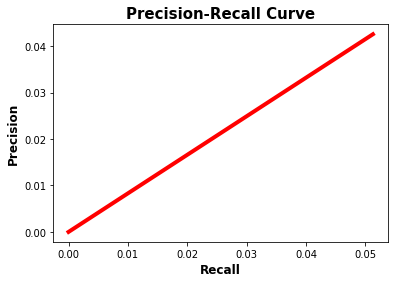

Validation round:   0%|          | 0/5 [00:00<?, ?samples/s]

0.0013638843426077467
metrics: [0.0013638843426077467]
img_class_path: lacoste
You have 70 triplets
loader: 5
truth_bboxes:  [(98, 110, 58, 19)]
truth_bboxes:  [(107, 85, 63, 65)]
truth_bboxes:  [(182, 171, 68, 50)]
truth_bboxes:  [(154, 105, 31, 29)]
truth_bboxes:  [(48, 37, 97, 54), (85, 175, 95, 39)]
truth_bboxes:  [(114, 109, 31, 22)]
truth_bboxes:  [(117, 131, 9, 7), (197, 140, 16, 13)]
truth_bboxes:  [(187, 78, 39, 31)]
truth_bboxes:  [(167, 163, 20, 18)]
truth_bboxes:  [(54, 45, 159, 116)]
truth_bboxes:  [(114, 101, 22, 38)]
truth_bboxes:  [(60, 156, 16, 23)]
truth_bboxes:  [(48, 109, 49, 22), (170, 72, 48, 22)]
truth_bboxes:  [(74, 142, 29, 26)]
truth_bboxes:  [(124, 92, 37, 25)]


Validation round: 16samples [00:10,  1.56samples/s]         

truth_bboxes:  [(163, 149, 16, 20)]
truth_bboxes:  [(92, 82, 71, 62)]
truth_bboxes:  [(64, 24, 37, 39), (153, 168, 65, 45)]
truth_bboxes:  [(120, 145, 22, 19)]
truth_bboxes:  [(110, 100, 16, 16), (190, 136, 16, 13)]
truth_bboxes:  [(186, 116, 12, 5)]
truth_bboxes:  [(60, 152, 84, 67)]
truth_bboxes:  [(53, 143, 38, 32)]
truth_bboxes:  [(145, 113, 23, 15)]
truth_bboxes:  [(86, 83, 83, 75)]
truth_bboxes:  [(144, 161, 52, 44)]
truth_bboxes:  [(82, 141, 20, 16), (126, 176, 10, 9), (195, 101, 10, 9)]
truth_bboxes:  [(149, 61, 19, 19)]
truth_bboxes:  [(126, 21, 7, 9), (177, 160, 20, 18)]
truth_bboxes:  [(56, 162, 22, 19), (187, 162, 23, 16)]
truth_bboxes:  [(156, 124, 18, 17)]


Validation round: 32samples [00:19,  1.61samples/s]

truth_bboxes:  [(117, 148, 47, 32)]
truth_bboxes:  [(32, 186, 57, 39), (142, 88, 21, 15)]
truth_bboxes:  [(118, 110, 26, 23)]
truth_bboxes:  [(113, 33, 33, 27)]
truth_bboxes:  [(98, 109, 57, 20)]
truth_bboxes:  [(22, 155, 10, 26), (147, 59, 11, 23)]
truth_bboxes:  [(106, 149, 52, 19)]
truth_bboxes:  [(175, 145, 14, 16)]
truth_bboxes:  [(99, 113, 46, 26)]
truth_bboxes:  [(89, 10, 29, 26), (106, 192, 28, 58)]
truth_bboxes:  [(229, 9, 14, 16)]
truth_bboxes:  [(79, 71, 31, 22), (173, 100, 27, 15)]
truth_bboxes:  [(86, 93, 89, 67)]
truth_bboxes:  [(143, 107, 19, 13)]
truth_bboxes:  [(167, 111, 16, 13)]
truth_bboxes:  [(15, 16, 29, 16), (167, 61, 8, 5)]
truth_bboxes:  [(122, 121, 16, 18)]


Validation round: 48samples [00:27,  1.73samples/s]

truth_bboxes:  [(83, 147, 22, 17), (169, 100, 18, 13)]
truth_bboxes:  [(106, 51, 89, 76)]
truth_bboxes:  [(139, 121, 35, 28)]
truth_bboxes:  [(95, 62, 107, 92)]
truth_bboxes:  [(47, 157, 10, 9), (132, 25, 59, 46)]
truth_bboxes:  [(159, 167, 14, 14)]
truth_bboxes:  [(61, 58, 138, 127)]
truth_bboxes:  [(87, 134, 20, 9), (90, 196, 14, 9), (101, 77, 17, 6)]
truth_bboxes:  [(165, 51, 36, 33)]
truth_bboxes:  [(154, 130, 23, 19)]
truth_bboxes:  [(38, 156, 49, 20)]
truth_bboxes:  [(121, 117, 15, 29)]
truth_bboxes:  [(69, 31, 109, 92)]
truth_bboxes:  [(92, 82, 23, 64)]
truth_bboxes:  [(65, 52, 64, 65)]


Validation round: 64samples [00:34,  1.83samples/s]

truth_bboxes:  [(107, 58, 40, 15), (136, 178, 31, 13)]
truth_bboxes:  [(30, 28, 44, 37)]
truth_bboxes:  [(168, 90, 66, 50)]
truth_bboxes:  [(118, 76, 34, 31)]
truth_bboxes:  [(145, 45, 24, 21)]
truth_bboxes:  [(40, 98, 13, 11), (132, 50, 42, 34)]


Validation round: 70samples [00:37,  1.86samples/s]

truth_bboxes:  [(81, 76, 101, 61)]
Precisions: [0.08333333333333333, 0.08333333333333333, 0.06481481481481481, 0.037037037037037035, 0.037037037037037035, 0.018518518518518517, 0.018518518518518517, 0.0, 0.0]    Recalls: [0.1, 0.1, 0.07777777777777778, 0.044444444444444446, 0.044444444444444446, 0.022222222222222223, 0.022222222222222223, 0.0, 0.0]    Accuracies: [0.047619047619047616, 0.047619047619047616, 0.03664921465968586, 0.020618556701030927, 0.020618556701030927, 0.01020408163265306, 0.01020408163265306, 0.0, 0.0]


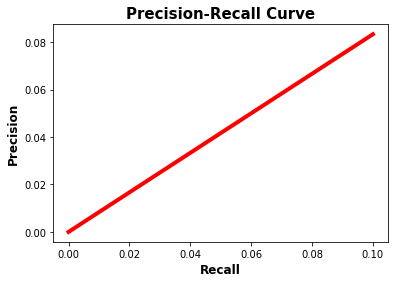

Validation round:   0%|          | 0/5 [00:00<?, ?samples/s]

0.005246913580246914
metrics: [0.0013638843426077467, 0.005246913580246914]
img_class_path: nike
You have 70 triplets
loader: 5
truth_bboxes:  [(130, 64, 25, 60)]
truth_bboxes:  [(69, 80, 28, 23), (92, 157, 16, 9), (141, 129, 27, 45)]
truth_bboxes:  [(116, 113, 54, 37), (155, 46, 52, 27)]
truth_bboxes:  [(96, 161, 47, 39)]
truth_bboxes:  [(74, 103, 16, 61)]
truth_bboxes:  [(99, 124, 28, 50)]
truth_bboxes:  [(130, 90, 50, 38)]
truth_bboxes:  [(80, 173, 16, 18), (122, 138, 42, 63)]
truth_bboxes:  [(37, 102, 31, 38), (176, 105, 37, 20)]
truth_bboxes:  [(70, 87, 23, 61), (132, 120, 46, 49)]
truth_bboxes:  [(28, 47, 69, 65)]
truth_bboxes:  [(25, 197, 10, 25), (134, 166, 13, 29), (214, 179, 10, 16)]
truth_bboxes:  [(190, 186, 32, 16)]
truth_bboxes:  [(93, 153, 67, 31)]
truth_bboxes:  [(152, 153, 21, 15), (198, 146, 21, 20)]


Validation round: 16samples [00:19,  1.22s/samples]         

truth_bboxes:  [(119, 103, 14, 7)]
truth_bboxes:  [(100, 114, 30, 18)]
truth_bboxes:  [(123, 137, 44, 28), (142, 52, 19, 10)]
truth_bboxes:  [(91, 152, 48, 82), (118, 39, 6, 11), (125, 105, 24, 9)]
truth_bboxes:  [(98, 74, 52, 40)]
truth_bboxes:  [(99, 141, 44, 42)]
truth_bboxes:  [(50, 99, 172, 82)]
truth_bboxes:  [(37, 42, 26, 9), (52, 195, 19, 41), (60, 91, 32, 12), (172, 57, 57, 25), (179, 163, 35, 17)]
truth_bboxes:  [(86, 92, 94, 65)]
truth_bboxes:  [(140, 156, 26, 28)]
truth_bboxes:  [(122, 97, 32, 48)]
truth_bboxes:  [(142, 88, 32, 67)]
truth_bboxes:  [(89, 101, 41, 45)]
truth_bboxes:  [(43, 74, 38, 18)]
truth_bboxes:  [(60, 22, 194, 108)]
truth_bboxes:  [(44, 33, 25, 57), (114, 107, 17, 12)]


Validation round: 32samples [00:30,  1.06s/samples]

truth_bboxes:  [(80, 69, 78, 98)]
truth_bboxes:  [(49, 179, 41, 29), (166, 96, 50, 45)]
truth_bboxes:  [(39, 173, 37, 26)]
truth_bboxes:  [(42, 116, 34, 26), (193, 92, 18, 77)]
truth_bboxes:  [(136, 137, 62, 40)]
truth_bboxes:  [(61, 99, 72, 58)]
truth_bboxes:  [(123, 97, 58, 91)]
truth_bboxes:  [(18, 182, 9, 29), (36, 167, 54, 40)]
truth_bboxes:  [(91, 79, 96, 70)]
truth_bboxes:  [(81, 105, 70, 26)]
truth_bboxes:  [(103, 45, 11, 21), (236, 238, 14, 9)]
truth_bboxes:  [(34, 64, 180, 89)]
truth_bboxes:  [(112, 107, 36, 29)]
truth_bboxes:  [(70, 134, 59, 42)]
truth_bboxes:  [(121, 85, 16, 50)]
truth_bboxes:  [(114, 97, 15, 10)]


Validation round: 48samples [00:40,  1.08samples/s]

truth_bboxes:  [(76, 172, 20, 33)]
truth_bboxes:  [(76, 47, 53, 35)]
truth_bboxes:  [(0, 96, 32, 35), (131, 141, 49, 36), (133, 17, 10, 9)]
truth_bboxes:  [(104, 103, 53, 43)]
truth_bboxes:  [(113, 89, 70, 33), (123, 201, 83, 33)]
truth_bboxes:  [(45, 126, 29, 19)]
truth_bboxes:  [(139, 51, 37, 27)]
truth_bboxes:  [(71, 147, 104, 64)]
truth_bboxes:  [(64, 151, 62, 44), (146, 49, 54, 108)]
truth_bboxes:  [(138, 94, 69, 73)]
truth_bboxes:  [(80, 119, 72, 42)]
truth_bboxes:  [(22, 77, 217, 103)]
truth_bboxes:  [(81, 67, 12, 14), (108, 70, 19, 68)]
truth_bboxes:  [(22, 82, 104, 68), (205, 91, 17, 37)]
truth_bboxes:  [(153, 80, 31, 12)]
truth_bboxes:  [(112, 119, 46, 44)]


Validation round: 64samples [00:54,  1.10samples/s]

truth_bboxes:  [(126, 136, 14, 8)]
truth_bboxes:  [(63, 69, 127, 102)]
truth_bboxes:  [(91, 88, 36, 18)]
truth_bboxes:  [(117, 97, 76, 91)]
truth_bboxes:  [(107, 111, 44, 12)]
truth_bboxes:  [(93, 171, 26, 19), (186, 122, 12, 6)]
truth_bboxes:  [(164, 150, 52, 29), (188, 49, 45, 36)]


Validation round: 70samples [00:58,  1.20samples/s]


Precisions: [0.043243243243243246, 0.032432432432432434, 0.016216216216216217, 0.010810810810810811, 0.005405405405405406, 0.005405405405405406, 0.0, 0.0, 0.0]    Recalls: [0.08080808080808081, 0.06060606060606061, 0.030303030303030304, 0.020202020202020204, 0.010101010101010102, 0.010101010101010102, 0.0, 0.0, 0.0]    Accuracies: [0.028985507246376812, 0.02158273381294964, 0.010676156583629894, 0.0070921985815602835, 0.0035335689045936395, 0.0035335689045936395, 0.0, 0.0, 0.0]


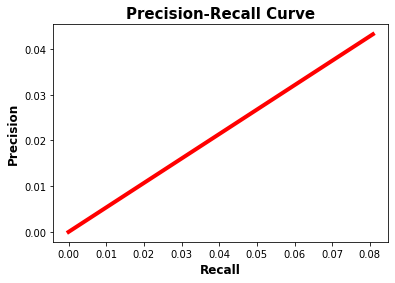

Validation round:   0%|          | 0/5 [00:00<?, ?samples/s]

0.002184002184002184
metrics: [0.0013638843426077467, 0.005246913580246914, 0.002184002184002184]
img_class_path: puma
You have 70 triplets
loader: 5
truth_bboxes:  [(39, 34, 22, 34)]
truth_bboxes:  [(26, 37, 212, 207)]
truth_bboxes:  [(26, 138, 63, 27)]
truth_bboxes:  [(69, 190, 26, 21), (156, 193, 28, 17)]
truth_bboxes:  [(168, 132, 14, 16)]
truth_bboxes:  [(14, 71, 69, 97)]
truth_bboxes:  [(28, 7, 173, 194)]
truth_bboxes:  [(131, 122, 32, 37)]
truth_bboxes:  [(221, 189, 16, 25)]
truth_bboxes:  [(80, 98, 31, 35)]
truth_bboxes:  [(154, 102, 17, 26)]
truth_bboxes:  [(33, 137, 18, 36), (178, 98, 18, 31), (227, 47, 16, 26)]
truth_bboxes:  [(27, 131, 81, 76)]
truth_bboxes:  [(97, 100, 48, 82)]
truth_bboxes:  [(58, 59, 46, 58)]
truth_bboxes:  [(192, 205, 61, 40)]


Validation round: 16samples [00:11,  1.35samples/s]         

truth_bboxes:  [(34, 145, 16, 37), (90, 51, 20, 43), (159, 125, 18, 37), (215, 54, 19, 34)]
truth_bboxes:  [(175, 104, 27, 26)]
truth_bboxes:  [(37, 15, 110, 132)]
truth_bboxes:  [(47, 68, 118, 130)]
truth_bboxes:  [(50, 129, 13, 23), (113, 154, 18, 17)]
truth_bboxes:  [(144, 22, 14, 11)]
truth_bboxes:  [(48, 17, 167, 183)]
truth_bboxes:  [(33, 110, 57, 39), (185, 71, 14, 16)]
truth_bboxes:  [(77, 62, 103, 103)]
truth_bboxes:  [(87, 42, 13, 19), (94, 202, 22, 29)]
truth_bboxes:  [(22, 169, 51, 36)]
truth_bboxes:  [(45, 52, 97, 136)]
truth_bboxes:  [(24, 134, 17, 23), (42, 15, 158, 52), (134, 173, 21, 42)]
truth_bboxes:  [(95, 99, 64, 50)]
truth_bboxes:  [(53, 110, 25, 39)]


Validation round: 32samples [00:26,  1.25samples/s]

truth_bboxes:  [(177, 151, 25, 22)]
truth_bboxes:  [(25, 38, 201, 192)]
truth_bboxes:  [(36, 106, 10, 15), (111, 202, 18, 19)]
truth_bboxes:  [(98, 89, 81, 33)]
truth_bboxes:  [(126, 59, 92, 73)]
truth_bboxes:  [(110, 98, 61, 34)]
truth_bboxes:  [(142, 79, 15, 16)]
truth_bboxes:  [(119, 152, 24, 31)]
truth_bboxes:  [(124, 120, 20, 17)]
truth_bboxes:  [(61, 120, 16, 22), (145, 139, 21, 23)]
truth_bboxes:  [(99, 157, 20, 31)]
truth_bboxes:  [(126, 103, 20, 27)]
truth_bboxes:  [(177, 142, 65, 77)]
truth_bboxes:  [(37, 17, 187, 198)]
truth_bboxes:  [(104, 33, 41, 33), (202, 165, 21, 19)]
truth_bboxes:  [(37, 88, 21, 22)]


Validation round: 48samples [00:36,  1.35samples/s]

truth_bboxes:  [(215, 60, 18, 40)]
truth_bboxes:  [(31, 64, 41, 49), (108, 120, 28, 73)]
truth_bboxes:  [(44, 127, 60, 38)]
truth_bboxes:  [(6, 177, 8, 12), (53, 25, 33, 29), (118, 194, 35, 34)]
truth_bboxes:  [(78, 89, 78, 58)]
truth_bboxes:  [(161, 89, 36, 55)]
truth_bboxes:  [(34, 58, 34, 32), (158, 60, 48, 31)]
truth_bboxes:  [(30, 108, 35, 36), (190, 103, 33, 33)]
truth_bboxes:  [(28, 66, 39, 28), (120, 33, 56, 33)]
truth_bboxes:  [(83, 37, 77, 52)]
truth_bboxes:  [(102, 122, 59, 107), (200, 98, 16, 19)]
truth_bboxes:  [(90, 112, 53, 26)]
truth_bboxes:  [(83, 131, 31, 20), (120, 28, 19, 22), (176, 44, 22, 23), (190, 155, 30, 18)]
truth_bboxes:  [(115, 116, 58, 65)]
truth_bboxes:  [(35, 48, 50, 59)]
truth_bboxes:  [(76, 196, 36, 28)]
truth_bboxes:  [(105, 117, 26, 22), (198, 159, 16, 26)]


Validation round: 64samples [00:56,  1.11samples/s]

truth_bboxes:  [(6, 56, 52, 38), (72, 195, 54, 39), (190, 80, 60, 45)]
truth_bboxes:  [(158, 100, 31, 34)]
truth_bboxes:  [(99, 220, 109, 34)]
truth_bboxes:  [(139, 55, 21, 21)]
truth_bboxes:  [(112, 61, 75, 50)]
truth_bboxes:  [(60, 0, 136, 37), (232, 168, 17, 10)]


Validation round: 70samples [01:00,  1.15samples/s]


Precisions: [0.03902439024390244, 0.03414634146341464, 0.024390243902439025, 0.01951219512195122, 0.014634146341463415, 0.00975609756097561, 0.0, 0.0, 0.0]    Recalls: [0.08163265306122448, 0.07142857142857142, 0.05102040816326531, 0.04081632653061224, 0.030612244897959183, 0.02040816326530612, 0.0, 0.0, 0.0]    Accuracies: [0.02711864406779661, 0.02364864864864865, 0.016778523489932886, 0.013377926421404682, 0.01, 0.006644518272425249, 0.0, 0.0, 0.0]


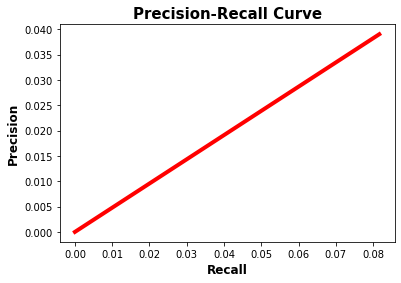

Validation round:   0%|          | 0/5 [00:00<?, ?samples/s]

0.0018914883026381283
metrics: [0.0013638843426077467, 0.005246913580246914, 0.002184002184002184, 0.0018914883026381283]
img_class_path: adidas0
You have 69 triplets
loader: 5
truth_bboxes:  [(92, 119, 78, 71)]
truth_bboxes:  [(91, 43, 63, 44)]
truth_bboxes:  [(102, 64, 32, 47), (228, 75, 24, 41)]
truth_bboxes:  [(184, 171, 33, 29)]
truth_bboxes:  [(58, 54, 103, 27)]
truth_bboxes:  [(114, 47, 16, 16), (152, 130, 31, 38)]
truth_bboxes:  [(22, 105, 38, 39), (168, 101, 37, 35), (191, 234, 55, 19)]
truth_bboxes:  [(164, 3, 42, 52)]
truth_bboxes:  [(32, 138, 39, 37), (93, 5, 96, 102), (110, 124, 52, 40)]
truth_bboxes:  [(128, 107, 43, 84)]
truth_bboxes:  [(87, 209, 11, 9), (121, 196, 33, 23)]
truth_bboxes:  [(120, 134, 19, 11), (183, 13, 51, 25)]
truth_bboxes:  [(90, 98, 26, 37)]
truth_bboxes:  [(77, 94, 55, 46)]
truth_bboxes:  [(118, 115, 84, 79)]


Validation round: 16samples [00:11,  1.38samples/s]         

truth_bboxes:  [(79, 68, 16, 16)]
truth_bboxes:  [(124, 145, 25, 31)]
truth_bboxes:  [(49, 135, 52, 54)]
truth_bboxes:  [(0, 4, 80, 59), (174, 189, 80, 55)]
truth_bboxes:  [(2, 41, 120, 124)]
truth_bboxes:  [(37, 199, 82, 31)]
truth_bboxes:  [(61, 80, 43, 20), (155, 67, 44, 22)]
truth_bboxes:  [(14, 2, 49, 33), (180, 121, 24, 17)]
truth_bboxes:  [(100, 27, 51, 47)]
truth_bboxes:  [(89, 139, 71, 43), (177, 113, 55, 35)]
truth_bboxes:  [(1, 10, 52, 97)]
truth_bboxes:  [(13, 87, 47, 44), (161, 86, 52, 49)]
truth_bboxes:  [(86, 86, 66, 71)]
truth_bboxes:  [(81, 183, 76, 41)]
truth_bboxes:  [(79, 56, 30, 29)]
truth_bboxes:  [(144, 53, 44, 45), (235, 127, 9, 17)]


Validation round: 32samples [00:22,  1.41samples/s]

truth_bboxes:  [(37, 47, 17, 31), (135, 12, 42, 44)]
truth_bboxes:  [(51, 43, 32, 24), (173, 155, 25, 13)]
truth_bboxes:  [(45, 8, 151, 183)]
truth_bboxes:  [(122, 127, 68, 50)]
truth_bboxes:  [(87, 74, 99, 69)]
truth_bboxes:  [(78, 17, 38, 36)]
truth_bboxes:  [(87, 95, 104, 80), (126, 46, 14, 24)]
truth_bboxes:  [(94, 157, 73, 33), (107, 121, 5, 15)]
truth_bboxes:  [(98, 39, 54, 38)]
truth_bboxes:  [(101, 47, 123, 147)]
truth_bboxes:  [(56, 35, 82, 140)]
truth_bboxes:  [(51, 84, 50, 53), (162, 91, 48, 55)]
truth_bboxes:  [(30, 59, 203, 79)]
truth_bboxes:  [(143, 79, 45, 37)]
truth_bboxes:  [(143, 34, 14, 20)]
truth_bboxes:  [(132, 130, 30, 24)]


Validation round: 48samples [00:33,  1.43samples/s]

truth_bboxes:  [(66, 32, 24, 25), (78, 167, 31, 32), (159, 34, 24, 22), (198, 164, 28, 26)]
truth_bboxes:  [(99, 69, 140, 34)]
truth_bboxes:  [(128, 143, 54, 42)]
truth_bboxes:  [(54, 103, 75, 52)]
truth_bboxes:  [(97, 142, 65, 46)]
truth_bboxes:  [(49, 127, 36, 44)]
truth_bboxes:  [(105, 63, 43, 24), (179, 63, 36, 24)]
truth_bboxes:  [(118, 81, 28, 29), (120, 194, 26, 10), (129, 182, 10, 10)]
truth_bboxes:  [(111, 132, 52, 64)]
truth_bboxes:  [(32, 201, 16, 7), (67, 132, 93, 66)]
truth_bboxes:  [(2, 146, 60, 63), (162, 6, 79, 90)]
truth_bboxes:  [(98, 112, 23, 9), (148, 110, 21, 9)]
truth_bboxes:  [(163, 151, 47, 48)]
truth_bboxes:  [(42, 141, 54, 85), (142, 26, 68, 56)]
truth_bboxes:  [(31, 9, 78, 102), (178, 80, 49, 54)]
truth_bboxes:  [(80, 107, 39, 64)]
truth_bboxes:  [(126, 102, 80, 71)]


Validation round: 64samples [00:44,  1.43samples/s]

truth_bboxes:  [(88, 91, 56, 89)]
truth_bboxes:  [(66, 29, 119, 51)]
truth_bboxes:  [(73, 128, 106, 56)]
truth_bboxes:  [(175, 152, 41, 30)]


Validation round: 69samples [00:47,  1.49samples/s]

truth_bboxes:  [(58, 10, 56, 84)]


Validation round: 69samples [00:47,  1.45samples/s]


Precisions: [0.11409395973154363, 0.10738255033557047, 0.10738255033557047, 0.087248322147651, 0.0738255033557047, 0.053691275167785234, 0.03355704697986577, 0.013422818791946308, 0.0]    Recalls: [0.1717171717171717, 0.16161616161616163, 0.16161616161616163, 0.13131313131313133, 0.1111111111111111, 0.08080808080808081, 0.050505050505050504, 0.020202020202020204, 0.0]    Accuracies: [0.0735930735930736, 0.06896551724137931, 0.06896551724137931, 0.05531914893617021, 0.046413502109704644, 0.03333333333333333, 0.0205761316872428, 0.008130081300813009, 0.0]


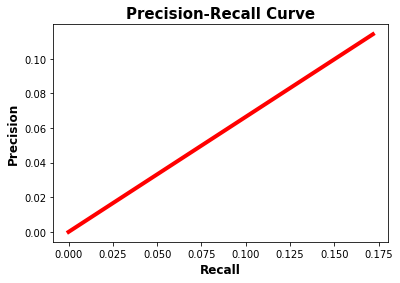

Validation round:   0%|          | 0/5 [00:00<?, ?samples/s]

0.0113212663548234
metrics: [0.0013638843426077467, 0.005246913580246914, 0.002184002184002184, 0.0018914883026381283, 0.0113212663548234]
img_class_path: hh
You have 70 triplets
loader: 5
truth_bboxes:  [(114, 40, 10, 5), (135, 24, 8, 5)]
truth_bboxes:  [(96, 106, 17, 6)]
truth_bboxes:  [(109, 65, 15, 22)]
truth_bboxes:  [(75, 10, 11, 11)]
truth_bboxes:  [(61, 93, 20, 12)]
truth_bboxes:  [(100, 70, 58, 50)]
truth_bboxes:  [(142, 58, 20, 8)]
truth_bboxes:  [(104, 128, 28, 18)]
truth_bboxes:  [(148, 84, 22, 14)]
truth_bboxes:  [(145, 120, 35, 14)]
truth_bboxes:  [(191, 2, 14, 22), (217, 39, 18, 17)]
truth_bboxes:  [(54, 42, 31, 23), (180, 63, 28, 17)]
truth_bboxes:  [(60, 114, 116, 82)]
truth_bboxes:  [(164, 19, 56, 40)]
truth_bboxes:  [(109, 47, 88, 76)]
truth_bboxes:  [(122, 77, 98, 88)]


Validation round: 16samples [00:10,  1.52samples/s]         

truth_bboxes:  [(151, 102, 20, 17)]
truth_bboxes:  [(129, 56, 24, 10)]
truth_bboxes:  [(183, 230, 40, 24)]
truth_bboxes:  [(124, 38, 29, 13)]
truth_bboxes:  [(61, 196, 15, 7), (123, 109, 7, 4), (202, 138, 6, 5)]
truth_bboxes:  [(141, 19, 29, 30)]
truth_bboxes:  [(106, 76, 15, 7)]
truth_bboxes:  [(130, 149, 4, 4)]
truth_bboxes:  [(227, 211, 27, 27)]
truth_bboxes:  [(223, 118, 17, 11)]
truth_bboxes:  [(82, 36, 63, 36)]
truth_bboxes:  [(156, 203, 17, 11)]
truth_bboxes:  [(177, 43, 33, 15)]
truth_bboxes:  [(146, 61, 20, 9)]
truth_bboxes:  [(198, 150, 30, 50)]
truth_bboxes:  [(99, 82, 87, 109), (219, 90, 25, 11)]


Validation round: 32samples [00:16,  1.73samples/s]

truth_bboxes:  [(154, 190, 21, 8)]
truth_bboxes:  [(169, 71, 25, 17)]
truth_bboxes:  [(62, 67, 84, 52)]
truth_bboxes:  [(121, 66, 11, 7)]
truth_bboxes:  [(105, 152, 18, 14)]
truth_bboxes:  [(62, 34, 84, 40)]
truth_bboxes:  [(118, 145, 36, 26)]
truth_bboxes:  [(93, 121, 160, 131)]
truth_bboxes:  [(146, 91, 18, 9)]
truth_bboxes:  [(167, 73, 26, 18)]
truth_bboxes:  [(158, 82, 25, 10)]
truth_bboxes:  [(75, 97, 29, 29)]
truth_bboxes:  [(167, 117, 9, 9)]
truth_bboxes:  [(113, 121, 44, 33)]
truth_bboxes:  [(172, 182, 35, 33)]
truth_bboxes:  [(41, 142, 21, 19), (169, 36, 8, 7), (248, 94, 7, 7)]


Validation round: 48samples [00:24,  1.83samples/s]

truth_bboxes:  [(195, 214, 18, 9)]
truth_bboxes:  [(89, 139, 48, 26)]
truth_bboxes:  [(163, 150, 27, 13)]
truth_bboxes:  [(44, 85, 26, 30)]
truth_bboxes:  [(152, 105, 19, 15)]
truth_bboxes:  [(100, 35, 36, 25), (125, 161, 32, 21)]
truth_bboxes:  [(142, 83, 20, 16)]
truth_bboxes:  [(103, 66, 60, 39)]
truth_bboxes:  [(34, 154, 15, 18)]
truth_bboxes:  [(159, 102, 35, 18)]
truth_bboxes:  [(105, 53, 20, 8)]
truth_bboxes:  [(60, 180, 29, 22)]
truth_bboxes:  [(142, 65, 19, 8)]
truth_bboxes:  [(165, 37, 26, 15)]
truth_bboxes:  [(115, 83, 40, 17)]


Validation round: 64samples [00:32,  1.90samples/s]

truth_bboxes:  [(125, 22, 14, 8), (152, 69, 15, 8)]
truth_bboxes:  [(144, 62, 16, 6)]
truth_bboxes:  [(99, 212, 13, 10)]
truth_bboxes:  [(35, 66, 158, 108)]
truth_bboxes:  [(165, 80, 20, 10)]
truth_bboxes:  [(100, 126, 9, 16)]
truth_bboxes:  [(105, 79, 49, 40)]


Validation round: 70samples [00:35,  1.98samples/s]


Precisions: [0.09523809523809523, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.0380952380952381, 0.009523809523809525, 0.0, 0.0, 0.0]    Recalls: [0.125, 0.0875, 0.0875, 0.0875, 0.05, 0.0125, 0.0, 0.0, 0.0]    Accuracies: [0.05714285714285714, 0.03932584269662921, 0.03932584269662921, 0.03932584269662921, 0.022099447513812154, 0.005434782608695652, 0.0, 0.0, 0.0]


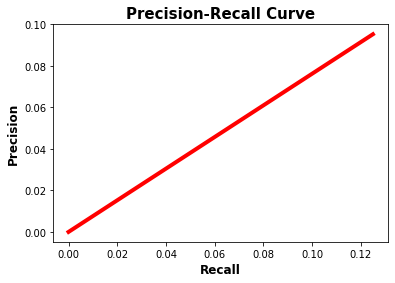

Validation round:   0%|          | 0/5 [00:00<?, ?samples/s]

0.007619047619047619
metrics: [0.0013638843426077467, 0.005246913580246914, 0.002184002184002184, 0.0018914883026381283, 0.0113212663548234, 0.007619047619047619]
img_class_path: supreme
You have 70 triplets
loader: 5
truth_bboxes:  [(58, 71, 105, 104)]
truth_bboxes:  [(111, 62, 26, 12)]
truth_bboxes:  [(39, 172, 96, 61)]
truth_bboxes:  [(47, 142, 160, 62)]
truth_bboxes:  [(36, 85, 190, 81)]
truth_bboxes:  [(78, 8, 80, 88)]
truth_bboxes:  [(102, 162, 57, 33)]
truth_bboxes:  [(64, 92, 125, 93)]
truth_bboxes:  [(90, 107, 118, 27)]
truth_bboxes:  [(98, 86, 44, 43)]
truth_bboxes:  [(60, 61, 161, 78)]
truth_bboxes:  [(71, 49, 54, 44)]
truth_bboxes:  [(109, 26, 89, 31)]
truth_bboxes:  [(187, 18, 28, 20)]
truth_bboxes:  [(14, 6, 171, 44)]


Validation round: 16samples [00:09,  1.75samples/s]         

truth_bboxes:  [(108, 93, 65, 58)]
truth_bboxes:  [(113, 92, 134, 67)]
truth_bboxes:  [(74, 76, 53, 22)]
truth_bboxes:  [(44, 101, 145, 48)]
truth_bboxes:  [(91, 140, 20, 17), (157, 81, 18, 129)]
truth_bboxes:  [(41, 66, 66, 21)]
truth_bboxes:  [(103, 70, 39, 19)]
truth_bboxes:  [(117, 97, 30, 15)]
truth_bboxes:  [(111, 89, 82, 53)]
truth_bboxes:  [(84, 55, 116, 53)]
truth_bboxes:  [(75, 91, 15, 26), (106, 91, 99, 41)]
truth_bboxes:  [(81, 83, 143, 59)]
truth_bboxes:  [(96, 96, 50, 42)]
truth_bboxes:  [(26, 75, 158, 134)]
truth_bboxes:  [(0, 49, 255, 121)]
truth_bboxes:  [(86, 103, 76, 37)]
truth_bboxes:  [(62, 98, 36, 9), (173, 82, 32, 11)]


Validation round: 32samples [00:18,  1.76samples/s]

truth_bboxes:  [(23, 114, 197, 50)]
truth_bboxes:  [(8, 76, 247, 159)]
truth_bboxes:  [(98, 31, 11, 80)]
truth_bboxes:  [(140, 210, 52, 26)]
truth_bboxes:  [(142, 123, 35, 19)]
truth_bboxes:  [(134, 34, 29, 21)]
truth_bboxes:  [(25, 2, 155, 103)]
truth_bboxes:  [(132, 65, 56, 16)]
truth_bboxes:  [(30, 36, 37, 35), (104, 173, 40, 26)]
truth_bboxes:  [(72, 147, 74, 14)]
truth_bboxes:  [(113, 129, 30, 17)]
truth_bboxes:  [(124, 34, 77, 25)]
truth_bboxes:  [(156, 107, 98, 46)]
truth_bboxes:  [(126, 137, 36, 14)]
truth_bboxes:  [(61, 95, 125, 64)]


Validation round: 48samples [00:26,  1.83samples/s]

truth_bboxes:  [(87, 74, 31, 9)]
truth_bboxes:  [(82, 16, 94, 45), (117, 150, 16, 8)]
truth_bboxes:  [(128, 106, 53, 39)]
truth_bboxes:  [(164, 86, 23, 14)]
truth_bboxes:  [(87, 100, 89, 61)]
truth_bboxes:  [(125, 181, 31, 19)]
truth_bboxes:  [(94, 72, 94, 85)]
truth_bboxes:  [(4, 19, 248, 115)]
truth_bboxes:  [(117, 176, 29, 22)]
truth_bboxes:  [(78, 3, 136, 205)]
truth_bboxes:  [(160, 116, 34, 22)]
truth_bboxes:  [(64, 45, 56, 72)]
truth_bboxes:  [(75, 20, 122, 181)]
truth_bboxes:  [(112, 149, 46, 19)]
truth_bboxes:  [(42, 80, 156, 90)]
truth_bboxes:  [(56, 132, 93, 66)]


Validation round: 64samples [00:34,  1.82samples/s]

truth_bboxes:  [(99, 208, 38, 25)]
truth_bboxes:  [(24, 93, 209, 99)]
truth_bboxes:  [(117, 83, 23, 12)]
truth_bboxes:  [(66, 106, 75, 37)]
truth_bboxes:  [(132, 130, 84, 43)]
truth_bboxes:  [(59, 140, 42, 13)]


Validation round: 70samples [00:37,  1.87samples/s]

truth_bboxes:  [(105, 66, 93, 25)]
Precisions: [0.24444444444444444, 0.2111111111111111, 0.18888888888888888, 0.16666666666666666, 0.14444444444444443, 0.07777777777777778, 0.044444444444444446, 0.022222222222222223, 0.011111111111111112]    Recalls: [0.29333333333333333, 0.25333333333333335, 0.22666666666666666, 0.2, 0.17333333333333334, 0.09333333333333334, 0.05333333333333334, 0.02666666666666667, 0.013333333333333334]    Accuracies: [0.15384615384615385, 0.13013698630136986, 0.11486486486486487, 0.1, 0.08552631578947369, 0.04430379746835443, 0.024844720496894408, 0.012269938650306749, 0.006097560975609756]


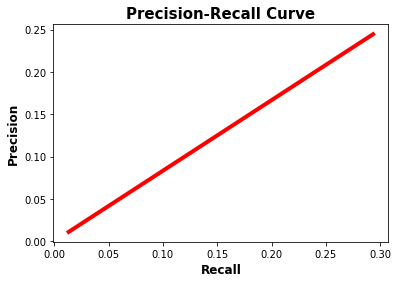

Validation round:   0%|          | 0/5 [00:00<?, ?samples/s]

0.04118518518518518
metrics: [0.0013638843426077467, 0.005246913580246914, 0.002184002184002184, 0.0018914883026381283, 0.0113212663548234, 0.007619047619047619, 0.04118518518518518]
img_class_path: prada
You have 70 triplets
loader: 5
truth_bboxes:  [(89, 121, 54, 32)]
truth_bboxes:  [(92, 113, 38, 14)]
truth_bboxes:  [(61, 126, 110, 29)]
truth_bboxes:  [(81, 116, 89, 36)]
truth_bboxes:  [(116, 177, 42, 17)]
truth_bboxes:  [(111, 94, 32, 18)]
truth_bboxes:  [(49, 70, 66, 12), (57, 125, 20, 7)]
truth_bboxes:  [(30, 104, 121, 56)]
truth_bboxes:  [(127, 85, 122, 99)]
truth_bboxes:  [(119, 112, 15, 5)]
truth_bboxes:  [(66, 61, 116, 96)]
truth_bboxes:  [(170, 92, 47, 22), (182, 173, 13, 5)]
truth_bboxes:  [(145, 123, 33, 18)]
truth_bboxes:  [(167, 183, 29, 15)]
truth_bboxes:  [(96, 108, 52, 15)]
truth_bboxes:  [(58, 72, 26, 21), (148, 93, 28, 35)]


Validation round: 16samples [00:11,  1.43samples/s]         

truth_bboxes:  [(120, 165, 47, 13)]
truth_bboxes:  [(156, 97, 24, 16)]
truth_bboxes:  [(162, 36, 54, 16)]
truth_bboxes:  [(78, 126, 36, 9), (78, 171, 37, 7)]
truth_bboxes:  [(130, 65, 18, 28)]
truth_bboxes:  [(106, 99, 31, 16)]
truth_bboxes:  [(22, 37, 56, 16), (152, 136, 25, 27)]
truth_bboxes:  [(117, 121, 64, 27)]
truth_bboxes:  [(88, 90, 84, 20)]
truth_bboxes:  [(98, 116, 73, 32)]
truth_bboxes:  [(31, 90, 56, 18)]
truth_bboxes:  [(60, 52, 69, 25)]
truth_bboxes:  [(71, 112, 118, 30)]
truth_bboxes:  [(124, 165, 38, 22)]
truth_bboxes:  [(121, 76, 28, 9)]
truth_bboxes:  [(117, 76, 57, 74)]


Validation round: 32samples [00:21,  1.46samples/s]

truth_bboxes:  [(189, 52, 27, 10)]
truth_bboxes:  [(29, 62, 24, 10), (192, 87, 11, 6)]
truth_bboxes:  [(52, 91, 169, 49)]
truth_bboxes:  [(124, 126, 44, 27)]
truth_bboxes:  [(75, 90, 108, 22)]
truth_bboxes:  [(51, 53, 162, 66)]
truth_bboxes:  [(110, 77, 19, 8)]
truth_bboxes:  [(85, 35, 94, 12)]
truth_bboxes:  [(64, 61, 47, 14)]
truth_bboxes:  [(118, 141, 30, 11)]
truth_bboxes:  [(71, 17, 46, 15), (208, 31, 30, 13)]
truth_bboxes:  [(131, 115, 57, 20)]
truth_bboxes:  [(125, 0, 65, 8), (227, 109, 21, 8)]
truth_bboxes:  [(61, 1, 131, 189)]
truth_bboxes:  [(40, 63, 116, 91)]


Validation round: 48samples [00:30,  1.54samples/s]

truth_bboxes:  [(55, 118, 33, 12)]
truth_bboxes:  [(114, 121, 45, 38)]
truth_bboxes:  [(84, 42, 18, 45), (153, 41, 15, 47)]
truth_bboxes:  [(30, 63, 25, 8), (134, 61, 46, 12)]
truth_bboxes:  [(39, 82, 198, 28), (121, 189, 53, 7)]
truth_bboxes:  [(166, 95, 44, 12)]
truth_bboxes:  [(126, 144, 44, 14)]
truth_bboxes:  [(65, 167, 19, 9), (150, 53, 59, 16)]
truth_bboxes:  [(48, 40, 124, 80)]
truth_bboxes:  [(102, 86, 39, 11)]
truth_bboxes:  [(123, 142, 22, 8)]
truth_bboxes:  [(36, 150, 68, 9), (40, 56, 109, 17)]
truth_bboxes:  [(127, 80, 17, 5)]
truth_bboxes:  [(99, 5, 69, 14)]
truth_bboxes:  [(72, 219, 87, 21)]
truth_bboxes:  [(61, 89, 42, 28)]


Validation round: 64samples [00:38,  1.67samples/s]

truth_bboxes:  [(83, 38, 104, 16)]
truth_bboxes:  [(26, 96, 202, 50)]
truth_bboxes:  [(110, 70, 50, 16)]
truth_bboxes:  [(102, 42, 103, 36)]
truth_bboxes:  [(66, 55, 115, 33)]
truth_bboxes:  [(74, 69, 127, 41)]


Validation round: 70samples [00:41,  1.68samples/s]

truth_bboxes:  [(26, 116, 73, 63)]
Precisions: [0.02702702702702703, 0.02027027027027027, 0.02027027027027027, 0.02027027027027027, 0.006756756756756757, 0.0, 0.0, 0.0, 0.0]    Recalls: [0.04819277108433735, 0.03614457831325301, 0.03614457831325301, 0.03614457831325301, 0.012048192771084338, 0.0, 0.0, 0.0, 0.0]    Accuracies: [0.01762114537444934, 0.013157894736842105, 0.013157894736842105, 0.013157894736842105, 0.004347826086956522, 0.0, 0.0, 0.0, 0.0]


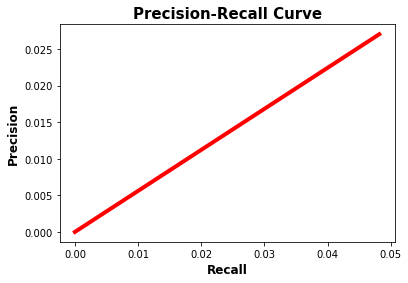

Validation round:   0%|          | 0/5 [00:00<?, ?samples/s]

0.0008954737870400523
metrics: [0.0013638843426077467, 0.005246913580246914, 0.002184002184002184, 0.0018914883026381283, 0.0113212663548234, 0.007619047619047619, 0.04118518518518518, 0.0008954737870400523]
img_class_path: chanel
You have 70 triplets
loader: 5
truth_bboxes:  [(94, 48, 84, 91)]
truth_bboxes:  [(97, 80, 90, 97)]
truth_bboxes:  [(115, 119, 26, 28)]
truth_bboxes:  [(127, 126, 18, 24)]
truth_bboxes:  [(92, 164, 18, 25)]
truth_bboxes:  [(64, 1, 187, 158)]
truth_bboxes:  [(91, 105, 54, 68)]
truth_bboxes:  [(2, 102, 186, 101)]
truth_bboxes:  [(76, 86, 85, 81)]
truth_bboxes:  [(65, 65, 101, 89)]
truth_bboxes:  [(114, 189, 20, 22)]
truth_bboxes:  [(101, 91, 51, 57)]
truth_bboxes:  [(84, 74, 92, 95)]
truth_bboxes:  [(42, 73, 30, 40), (113, 145, 41, 53)]
truth_bboxes:  [(90, 92, 13, 25), (159, 163, 14, 27)]
truth_bboxes:  [(92, 154, 66, 65)]


Validation round: 16samples [00:10,  1.49samples/s]         

truth_bboxes:  [(137, 121, 37, 51)]
truth_bboxes:  [(121, 58, 27, 15)]
truth_bboxes:  [(100, 147, 31, 23)]
truth_bboxes:  [(110, 156, 26, 30)]
truth_bboxes:  [(119, 118, 14, 18)]
truth_bboxes:  [(125, 141, 19, 18)]
truth_bboxes:  [(115, 112, 22, 22)]
truth_bboxes:  [(65, 50, 92, 103)]
truth_bboxes:  [(69, 44, 152, 75), (193, 166, 25, 22)]
truth_bboxes:  [(103, 119, 40, 22), (105, 179, 39, 20)]
truth_bboxes:  [(58, 93, 60, 80)]
truth_bboxes:  [(114, 109, 36, 38)]
truth_bboxes:  [(39, 144, 48, 25)]
truth_bboxes:  [(33, 102, 34, 41), (165, 109, 41, 44)]
truth_bboxes:  [(33, 128, 109, 90)]


Validation round: 32samples [00:19,  1.57samples/s]

truth_bboxes:  [(122, 81, 94, 99)]
truth_bboxes:  [(50, 132, 11, 22), (236, 171, 7, 16)]
truth_bboxes:  [(24, 139, 28, 46)]
truth_bboxes:  [(69, 56, 20, 23), (169, 54, 22, 25)]
truth_bboxes:  [(116, 64, 30, 28)]
truth_bboxes:  [(64, 117, 125, 91)]
truth_bboxes:  [(158, 97, 21, 37)]
truth_bboxes:  [(104, 122, 34, 43)]
truth_bboxes:  [(137, 5, 32, 44), (141, 98, 36, 25)]
truth_bboxes:  [(62, 117, 20, 19), (162, 150, 22, 22)]
truth_bboxes:  [(150, 182, 52, 72)]
truth_bboxes:  [(119, 38, 30, 37)]
truth_bboxes:  [(77, 35, 96, 95)]
truth_bboxes:  [(150, 106, 28, 37)]
truth_bboxes:  [(50, 154, 71, 37)]
truth_bboxes:  [(77, 65, 37, 31)]
truth_bboxes:  [(53, 89, 86, 103)]


Validation round: 48samples [00:29,  1.58samples/s]

truth_bboxes:  [(118, 114, 20, 30), (145, 117, 15, 28)]
truth_bboxes:  [(120, 195, 29, 18)]
truth_bboxes:  [(105, 104, 42, 49)]
truth_bboxes:  [(86, 135, 63, 18)]
truth_bboxes:  [(121, 71, 37, 36)]
truth_bboxes:  [(88, 2, 61, 79)]
truth_bboxes:  [(120, 141, 58, 69)]
truth_bboxes:  [(49, 30, 41, 39)]
truth_bboxes:  [(57, 53, 127, 133)]
truth_bboxes:  [(69, 122, 35, 29)]
truth_bboxes:  [(135, 87, 42, 24)]
truth_bboxes:  [(31, 81, 186, 109)]
truth_bboxes:  [(157, 125, 17, 23)]
truth_bboxes:  [(118, 146, 19, 22)]
truth_bboxes:  [(124, 115, 24, 29)]
truth_bboxes:  [(49, 87, 15, 18)]


Validation round: 64samples [00:40,  1.54samples/s]

truth_bboxes:  [(102, 102, 136, 82)]
truth_bboxes:  [(90, 122, 92, 89)]
truth_bboxes:  [(122, 121, 25, 31)]
truth_bboxes:  [(99, 86, 22, 33)]
truth_bboxes:  [(43, 1, 176, 236)]
truth_bboxes:  [(53, 133, 45, 47), (155, 54, 34, 55)]


Validation round: 70samples [00:47,  1.49samples/s]


Precisions: [0.0784313725490196, 0.058823529411764705, 0.058823529411764705, 0.0457516339869281, 0.0392156862745098, 0.013071895424836602, 0.013071895424836602, 0.013071895424836602, 0.006535947712418301]    Recalls: [0.14814814814814814, 0.1111111111111111, 0.1111111111111111, 0.08641975308641975, 0.07407407407407407, 0.024691358024691357, 0.024691358024691357, 0.024691358024691357, 0.012345679012345678]    Accuracies: [0.05405405405405406, 0.04, 0.04, 0.030837004405286344, 0.02631578947368421, 0.008620689655172414, 0.008620689655172414, 0.008620689655172414, 0.004291845493562232]


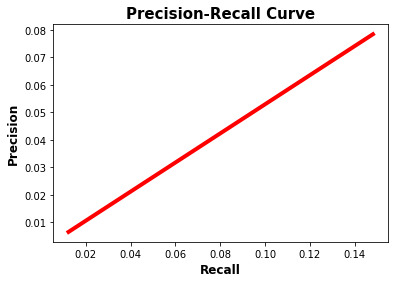

Validation round:   0%|          | 0/5 [00:00<?, ?samples/s]

0.00710078269991124
metrics: [0.0013638843426077467, 0.005246913580246914, 0.002184002184002184, 0.0018914883026381283, 0.0113212663548234, 0.007619047619047619, 0.04118518518518518, 0.0008954737870400523, 0.00710078269991124]
img_class_path: mk
You have 70 triplets
loader: 5
truth_bboxes:  [(162, 36, 32, 61)]
truth_bboxes:  [(184, 65, 22, 39)]
truth_bboxes:  [(37, 79, 46, 69), (110, 63, 44, 68)]
truth_bboxes:  [(146, 148, 55, 36)]
truth_bboxes:  [(99, 88, 32, 41), (170, 185, 23, 33)]
truth_bboxes:  [(52, 22, 153, 202)]
truth_bboxes:  [(141, 154, 17, 26)]
truth_bboxes:  [(137, 181, 14, 18)]
truth_bboxes:  [(95, 100, 69, 64)]
truth_bboxes:  [(149, 211, 21, 21)]
truth_bboxes:  [(117, 35, 40, 76)]
truth_bboxes:  [(56, 66, 147, 141)]
truth_bboxes:  [(113, 136, 26, 27)]
truth_bboxes:  [(198, 112, 22, 30)]
truth_bboxes:  [(157, 171, 19, 28)]


Validation round: 16samples [00:11,  1.34samples/s]         

truth_bboxes:  [(128, 124, 75, 37)]
truth_bboxes:  [(61, 141, 17, 25)]
truth_bboxes:  [(174, 150, 37, 23)]
truth_bboxes:  [(90, 152, 18, 28), (118, 147, 18, 27)]
truth_bboxes:  [(111, 126, 41, 44)]
truth_bboxes:  [(168, 194, 34, 26)]
truth_bboxes:  [(114, 44, 33, 44)]
truth_bboxes:  [(132, 132, 19, 36)]
truth_bboxes:  [(164, 168, 21, 17)]
truth_bboxes:  [(138, 91, 26, 24)]
truth_bboxes:  [(157, 235, 8, 14)]
truth_bboxes:  [(23, 163, 31, 53), (120, 140, 32, 54), (193, 160, 24, 43)]
truth_bboxes:  [(28, 78, 80, 74)]
truth_bboxes:  [(84, 189, 17, 26)]
truth_bboxes:  [(136, 78, 34, 37)]
truth_bboxes:  [(102, 112, 63, 46)]


Validation round: 32samples [00:21,  1.42samples/s]

truth_bboxes:  [(118, 105, 35, 26)]
truth_bboxes:  [(126, 108, 57, 77)]
truth_bboxes:  [(117, 115, 21, 29)]
truth_bboxes:  [(168, 110, 12, 10)]
truth_bboxes:  [(23, 161, 32, 27), (112, 180, 31, 28)]
truth_bboxes:  [(161, 86, 83, 148)]
truth_bboxes:  [(174, 179, 12, 11)]
truth_bboxes:  [(101, 59, 65, 104)]
truth_bboxes:  [(150, 199, 17, 18)]
truth_bboxes:  [(60, 45, 42, 35)]
truth_bboxes:  [(82, 69, 92, 132)]
truth_bboxes:  [(163, 143, 19, 23)]
truth_bboxes:  [(166, 22, 26, 43)]
truth_bboxes:  [(26, 60, 211, 118)]
truth_bboxes:  [(109, 183, 19, 67)]
truth_bboxes:  [(172, 142, 35, 22)]
truth_bboxes:  [(97, 190, 84, 62)]


Validation round: 48samples [00:31,  1.47samples/s]

truth_bboxes:  [(171, 111, 46, 30)]
truth_bboxes:  [(135, 97, 42, 49)]
truth_bboxes:  [(28, 85, 52, 54), (164, 73, 52, 65)]
truth_bboxes:  [(114, 132, 45, 48)]
truth_bboxes:  [(178, 58, 46, 62)]
truth_bboxes:  [(94, 105, 86, 87)]
truth_bboxes:  [(122, 27, 39, 81)]
truth_bboxes:  [(211, 163, 29, 29)]
truth_bboxes:  [(156, 199, 25, 32)]
truth_bboxes:  [(146, 191, 18, 25)]
truth_bboxes:  [(174, 186, 33, 32)]
truth_bboxes:  [(94, 25, 140, 154)]
truth_bboxes:  [(100, 65, 19, 32)]
truth_bboxes:  [(69, 53, 123, 141)]
truth_bboxes:  [(187, 191, 16, 20)]


Validation round: 64samples [00:41,  1.53samples/s]

truth_bboxes:  [(36, 164, 28, 37)]
truth_bboxes:  [(197, 193, 17, 23)]
truth_bboxes:  [(129, 17, 37, 24)]
truth_bboxes:  [(186, 139, 24, 31)]
truth_bboxes:  [(203, 152, 20, 15)]
truth_bboxes:  [(137, 134, 20, 27)]


Validation round: 70samples [00:43,  1.68samples/s]

truth_bboxes:  [(147, 111, 45, 71)]


Validation round: 70samples [00:43,  1.60samples/s]


Precisions: [0.17699115044247787, 0.17699115044247787, 0.168141592920354, 0.1592920353982301, 0.1504424778761062, 0.13274336283185842, 0.08849557522123894, 0.04424778761061947, 0.035398230088495575]    Recalls: [0.2597402597402597, 0.2597402597402597, 0.24675324675324675, 0.23376623376623376, 0.22077922077922077, 0.19480519480519481, 0.12987012987012986, 0.06493506493506493, 0.05194805194805195]    Accuracies: [0.11764705882352941, 0.11764705882352941, 0.1111111111111111, 0.10465116279069768, 0.09826589595375723, 0.08571428571428572, 0.05555555555555555, 0.02702702702702703, 0.021505376344086023]


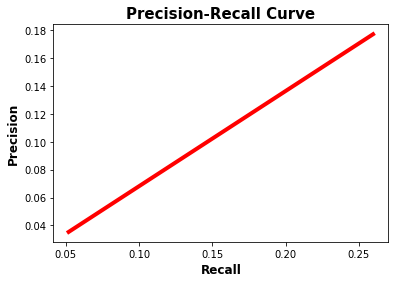

0.027238248477186526
metrics: [0.0013638843426077467, 0.005246913580246914, 0.002184002184002184, 0.0018914883026381283, 0.0113212663548234, 0.007619047619047619, 0.04118518518518518, 0.0008954737870400523, 0.00710078269991124, 0.027238248477186526]


In [9]:
test_main(batch_size=16, 
#           dataset_name="TopLogos-10",
#           skip_bbox_lines=1,
          dataset_name="TopLogos-10",
          skip_bbox_lines=1,
#           dataset_name="TopLogos-10",
#           skip_bbox_lines=1,
          vgg_cfg='B',
          load="data/stored_models/checkpoints/CP_epoch45.pt"
         )